# Unsupervised Anomaly Detection based on TCNForecaster

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do anomaly detection using Chronos `TCNForecaster`.

For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction <a href="https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md" target="_blank">here</a>. In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>.

## Helper function

This section provides a helper function to plot the ground truth, prediction and anomaly value. You can refer to it later when use.

In [1]:
def plot_anomalies_value(y_true, y_pred, ano_index):
    """
    Plot the ground truth, prediction and anomaly value.
    """
    df = pd.DataFrame({"y_true": y_true.squeeze(), "y_pred": y_pred.squeeze()})
    df['ano_index'] = 0
    df.loc[df.index[ano_index], 'ano_index'] = 1

    fig, axs = plt.subplots(figsize=(16,6))
    axs.plot(df.index, df.y_true, color='blue', label='Ground Truth')
    axs.plot(df.index, df.y_pred, color='orange', label='Prediction')
    axs.scatter(df.index[ano_index].tolist(), df.y_true[ano_index], color='red', label='anomaly values')
    axs.set_title('The Anomaly Values')
    
    plt.xlabel('time_step')
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe.Steps are as below:
* First, download the raw data <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>. Or run the script `get_data.sh` to download the raw data.It will download the resource usage of each machine from m_1932 to m_2085. 
* Second, run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932. Or run `extract_data.sh`.We use machine 1932 as an example in this notebook.You can choose any machines in the similar way.
* Finally, use pandas to load `m_1932.csv` into a dataframe as shown below.

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage", "mem_usage"])

Below are some example records of the data

In [4]:
df_1932.head()

,time_step,cpu_usage,mem_usage
0,386640,41,92
1,386670,43,92
2,386690,44,92
3,386800,46,92
4,386930,44,93


<AxesSubplot:title={'center':'cpu_usage of machine 1932'}, xlabel='time_step'>

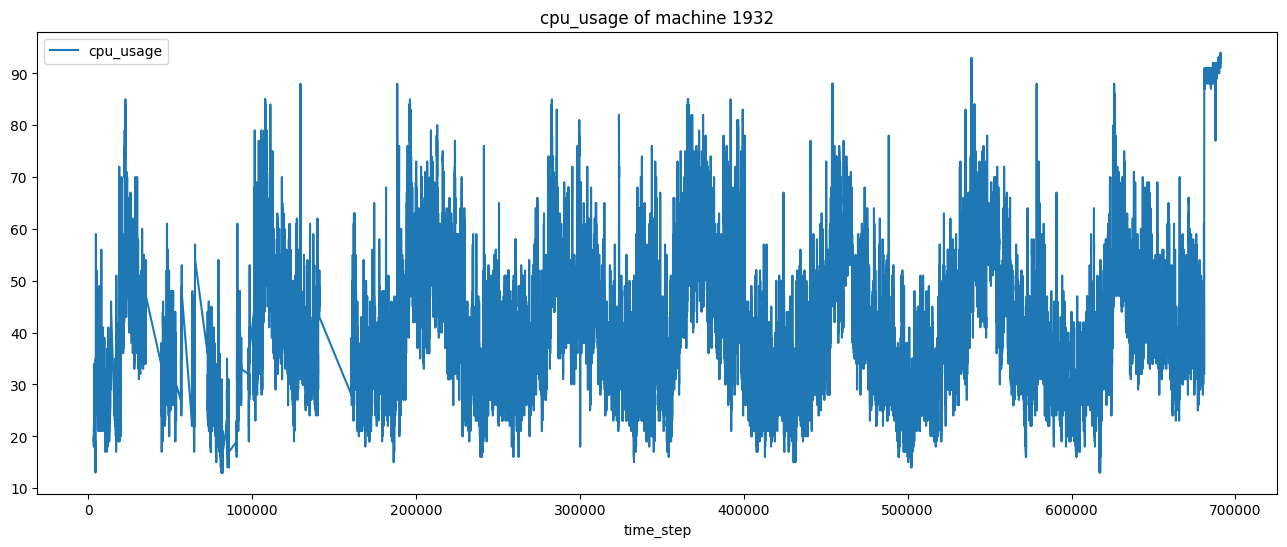

In [5]:
df_1932.sort_values(by="time_step", inplace=True)
df_1932.reset_index(inplace=True)
df_1932.plot(y="cpu_usage", x="time_step", figsize=(16,6), title="cpu_usage of machine 1932")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the machine_usage data, the pre-processing convert the time step in seconds to timestamp starting from 2018-01-01.

In [6]:
df_1932["time_step"] = pd.to_datetime(df_1932["time_step"], unit='s', origin=pd.Timestamp('2018-01-01'))

## Feature Engineering & Data Preperation

For feature engineering, we use hour of the time stamp as feature in addition to the target cpu usage.

For data preperation, we resample the average of cpu_usage in minutes, impute the data to handle missing data and scale the data. At last we generate the sample in numpy ndarray for TCNForecaster to use.

We use <a href="https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html" target="_blank">TSDataset</a> to complete the whole processing.

In [7]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

# look back one hour data which is of the frequency of 1min.
lookback = 60
horizon = 1

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df_1932, dt_col="time_step", target_col="cpu_usage", with_split=True, val_ratio = 0.1, test_ratio=0.1)
standard_scaler = StandardScaler()

for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.resample(interval='1min', merge_mode="mean")\
          .impute(mode="last")\
          .gen_dt_feature()\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=lookback, horizon=horizon, feature_col = ["HOUR"])

x_train, y_train = tsdata_train.to_numpy()
x_val, y_val = tsdata_val.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((9319, 60, 2),
 (9319, 1, 1),
 (975, 60, 2),
 (975, 1, 1),
 (991, 60, 2),
 (991, 1, 1))

## Time series forecasting

In [8]:
from bigdl.chronos.forecaster import TCNForecaster

First, we initialize a TCNForecaster based on time step and feature number. More information about TCNForecaster can be found <a href="https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html#tcnforecaster" target="_blank">here</a>.

In [9]:
forecaster = TCNForecaster(past_seq_len=lookback,
                           future_seq_len=horizon,
                           input_feature_num=2,
                           output_feature_num=1)

INFO:pytorch_lightning.utilities.seed:Global seed set to 3769778885
INFO:pytorch_lightning.utilities.seed:Global seed set to 3769778885


Now we train the model and wait till it finished.

In [10]:
forecaster.fit(data=tsdata_train, epochs=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 4.4 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Then we can use the fitted forecaster for prediction and inverse the scaling of the prediction results. 

In [11]:
y_pred_val = forecaster.predict(x_val)
y_pred_test = forecaster.predict(x_test)

In [12]:
y_pred_val_unscale = tsdata_val.unscale_numpy(y_pred_val)
y_pred_test_unscale = tsdata_test.unscale_numpy(y_pred_test)
y_val_unscale = tsdata_val.unscale_numpy(y_val)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

Calculate the symetric mean absolute percentage error (sMAPE).

In [13]:
from bigdl.chronos.metric.forecast_metrics import Evaluator
smape = Evaluator.evaluate("smape", y_test_unscale, y_pred_test_unscale)
print(f"sMAPE is {'%.2f' % smape[0]}")

sMAPE is 3.53


## Anomaly detection

In [14]:
from bigdl.chronos.detector.anomaly import ThresholdDetector
thd = ThresholdDetector()
thd.fit(y_val_unscale, y_pred_val_unscale)

In [15]:
val_anomaly_indexes = thd.anomaly_indexes()
print("The index of anomalies in validation dataset is:", val_anomaly_indexes)

The index of anomalies in validation dataset is: [789, 790, 791, 151, 152, 410, 795, 923, 800, 41, 42, 939, 43, 554, 555, 940, 941, 942, 943, 944, 945, 946, 54, 947, 948, 590, 734, 222, 234]


In [16]:
test_anomaly_indexes = thd.anomaly_indexes(y_pred=y_pred_test_unscale)
print("The index of anoalies in test dataset according to predict data is:", test_anomaly_indexes)

The index of anoalies in test dataset according to predict data is: [532, 533, 534, 564, 565, 566, 567, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 496, 498, 499]


Now, we obtain index of anomaly values in val and test dataset, use `plot_anomalies_value` to intuitively feel the detection results.

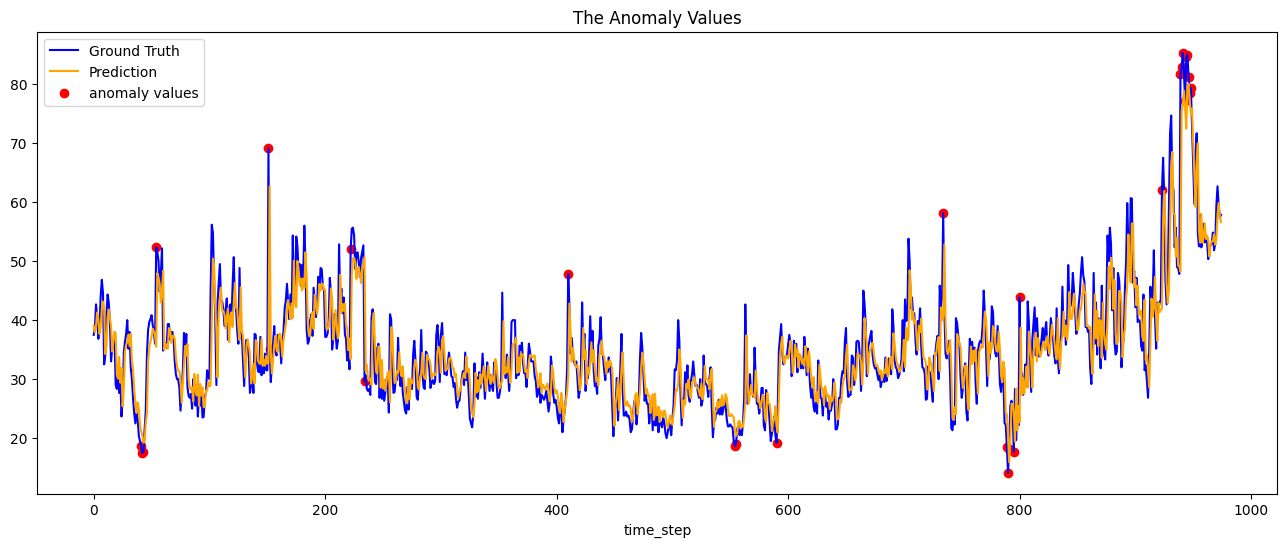

In [17]:
plot_anomalies_value(y_val_unscale, y_pred_val_unscale, val_anomaly_indexes)

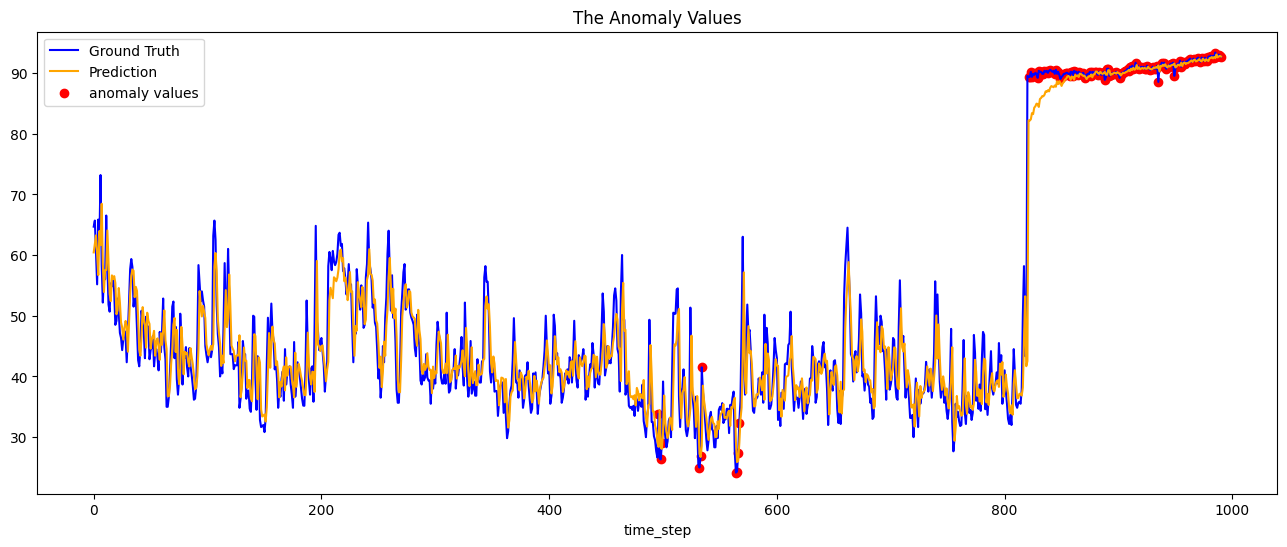

In [18]:
plot_anomalies_value(y_test_unscale, y_pred_test_unscale, test_anomaly_indexes)